In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from utils.plot_utils import *
np.set_printoptions(precision=3, suppress=True)

warnings.filterwarnings('ignore')

# Learning a model from WT data

In [2]:
from utils.library.composite_library import fill_group_info, collect_library, take_time_derivatives, decompose_library
from utils.library.extra_functions import *
        
libraries = [
    ('m_ij', 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP', 'tensor_library', 'tensor_SVDPipeline_PMG_CF.pkl'),
    ('v', 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP', 'tensor_library', None), #Not focused on flow dynamics
    ('c', 'Public/WT/ECad-GFP', 'scalar_library', None), #Not focused on cadherin dynamics, just include it as a source
]

    
extra_functions = [
    lambda data: material_derivative_terms(data, key='m_ij'),
    lambda data: active_strain_decomposition(data, key='m_ij'),
    lambda data: add_static_sources(data, couple='m_ij'),
    lambda data: symmetric_tensor_couple(data, ['m_ij', 'E_active', 'E_passive', 'E_full']),
    lambda data: multiply_tensor_by_scalar(data, None, ['c']),
]


with h5py.File(os.path.join(libraries[0][1], 'derivative_library.h5'), 'r') as h5f:
    embryoIDs = list(h5f.keys())

with h5py.File('Public/mechanical_feedback_fitting.h5', 'w') as data:
    with tqdm(total=len(embryoIDs)) as pbar:
        pbar.set_description('Collecting embryo data')
        for embryoID in embryoIDs:
            pbar.set_postfix(embryoID=embryoID)
            group, feature_names = fill_group_info(data, embryoID, libraries)
            collect_library(group, 
                            libraries, 
                            feature_names, 
                            extra_functions=extra_functions)
            take_time_derivatives(group, libraries, window_length=9)
            decompose_library(group, libraries)
            
            pbar.update()

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

## Training data covers VF and GBE onset (original method)

In [51]:
with h5py.File('Public/mechanical_feedback_fitting.h5', 'r') as h5f:
    X, X_dot, feature_names = collect_data(h5f, 'm_ij', collect_function=collect_raw_data,
                                           tmin=-5, tmax=10)

threshold, alpha = 1e-2, 1e1
sindy = FlySINDy(
    optimizer=ps.STLSQ(threshold=threshold, alpha=alpha, normalize_columns=True),
    feature_names = feature_names,
    n_models=10,
    n_candidates_to_drop=0,
    subset_fraction=0.1)
sindy.fit(x=X, x_dot=X_dot)
print(f'\nThreshold = {threshold:g}, Alpha = {alpha:g}')
sindy.print(lhs=['D_t m_ij'])

  0%|          | 0/7 [00:00<?, ?it/s]


Threshold = 0.01, Alpha = 10
D_t m_ij = (0.052 + -0.036 c) Static_DV Tr(m_ij) + (-0.086 + 0.076 c) m_ij + (0.496 + 0.312 c) m_ij Tr(E_full) + (0.678 + -0.504 c) m_ij Tr(m_ij)


## Training data restricted to VF

In [72]:
from utils.modeling.sindy_utils import *
from utils.modeling.fly_sindy import *
np.set_printoptions(precision=3, suppress=True)

with h5py.File('Public/mechanical_feedback_fitting.h5', 'r') as h5f:
    X, X_dot, feature_names = collect_data(h5f, 'm_ij', collect_function=collect_raw_data,
                                           tmin=-2, tmax=2)

for threshold in [1e-3, 5e-3, 1e-2, 5e-2]:
    for alpha in [1e-1, 1e0, 1e1]:
        sindy = FlySINDy(
            optimizer=ps.STLSQ(threshold=threshold, alpha=alpha, normalize_columns=True),
            feature_names = feature_names,
            n_models=10,
            n_candidates_to_drop=0,
            subset_fraction=0.1)
        sindy.fit(x=X.copy(), x_dot=X_dot.copy())
        print(f'\nThreshold = {threshold:g}, Alpha = {alpha:g}')
        sindy.print(lhs=['D_t m_ij'])
        

  0%|          | 0/7 [00:00<?, ?it/s]


Threshold = 0.001, Alpha = 0.1
D_t m_ij = (0.002 + -0.007 c) E_ij + 0.227 c E_ij Tr(m_ij) + (0.046 + -0.050 c) Static_DV Tr(m_ij) + (0.012 + 0.007 c) m_ij + (-0.307 + 0.830 c) m_ij Tr(E_ij) + (-0.135 + 0.304 c) m_ij Tr(m_ij) + (-0.935 + 0.982 c) {m_ij, E_ij}

Threshold = 0.001, Alpha = 1
D_t m_ij = (-0.585 + 0.773 c) E_ij Tr(m_ij) + (0.050 + -0.052 c) Static_DV Tr(m_ij) + (0.017 + 0.002 c) m_ij + (-0.928 + 1.435 c) m_ij Tr(E_ij) + (-0.202 + 0.372 c) m_ij Tr(m_ij)

Threshold = 0.001, Alpha = 10
D_t m_ij = (0.035 + -0.039 c) Static_DV Tr(m_ij) + (0.029 + -0.009 c) m_ij + (-0.930 + 1.544 c) m_ij Tr(E_ij) + (-0.172 + 0.350 c) m_ij Tr(m_ij)

Threshold = 0.005, Alpha = 0.1
D_t m_ij = 0.178 c E_ij Tr(m_ij) + (0.001 + -0.001 c) Static_DV + -0.006 Static_DV Tr(m_ij) + (0.049 + -0.032 c) m_ij + (-0.924 + 1.419 c) m_ij Tr(E_ij) + (-0.009 + 0.241 c) m_ij Tr(m_ij) + 0.038 c {m_ij, E_ij}

Threshold = 0.005, Alpha = 1
D_t m_ij = (0.029 + -0.034 c) Static_DV Tr(m_ij) + (0.030 + -0.009 c) m_ij + (-0.6

In [73]:
from utils.modeling.sindy_utils import *
from utils.modeling.fly_sindy import *
np.set_printoptions(precision=3, suppress=True)

with h5py.File('Public/mechanical_feedback_fitting.h5', 'r') as h5f:
    X, X_dot, feature_names = collect_data(h5f, 'm_ij', collect_function=collect_raw_data,
                                           tmin=-2, tmax=4)

for threshold in [1e-3, 5e-3, 1e-2, 5e-2]:
    for alpha in [1e-1, 1e0, 1e1]:
        sindy = FlySINDy(
            optimizer=ps.STLSQ(threshold=threshold, alpha=alpha, normalize_columns=True),
            feature_names = feature_names,
            n_models=10,
            n_candidates_to_drop=0,
            subset_fraction=0.1)
        sindy.fit(x=X.copy(), x_dot=X_dot.copy())
        print(f'\nThreshold = {threshold:g}, Alpha = {alpha:g}')
        sindy.print(lhs=['D_t m_ij'])
        

  0%|          | 0/7 [00:00<?, ?it/s]


Threshold = 0.001, Alpha = 0.1
D_t m_ij = -0.007 E_ij + (0.384 + -0.208 c) E_ij Tr(m_ij) + (0.042 + -0.045 c) Static_DV Tr(m_ij) + (0.024 + 0.002 c) m_ij + (0.422 + 0.230 c) m_ij Tr(E_ij) + (-0.196 + 0.281 c) m_ij Tr(m_ij) + (-1.642 + 1.752 c) {m_ij, E_ij}

Threshold = 0.001, Alpha = 1
D_t m_ij = (0.238 + -0.095 c) E_ij Tr(m_ij) + (0.046 + -0.049 c) Static_DV Tr(m_ij) + (0.001 + 0.016 c) m_ij + (0.342 + 0.298 c) m_ij Tr(E_ij) + (-0.011 + 0.183 c) m_ij Tr(m_ij) + (-1.445 + 1.537 c) {m_ij, E_ij}

Threshold = 0.001, Alpha = 10
D_t m_ij = (-0.664 + 0.792 c) E_ij Tr(m_ij) + (0.052 + -0.054 c) Static_DV Tr(m_ij) + (0.021 + 0.005 c) m_ij + (0.051 + 0.605 c) m_ij Tr(E_ij) + (-0.295 + 0.362 c) m_ij Tr(m_ij) + 0.051 c {m_ij, E_ij}

Threshold = 0.005, Alpha = 0.1
D_t m_ij = 0.103 c E_ij Tr(m_ij) + (0.001 + -0.001 c) Static_DV + -0.005 Static_DV Tr(m_ij) + (0.052 + -0.025 c) m_ij + (0.305 + 0.375 c) m_ij Tr(E_ij) + (-0.062 + 0.127 c) m_ij Tr(m_ij) + 0.111 c {m_ij, E_ij}

Threshold = 0.005, Alpha 

In [74]:
from utils.modeling.sindy_utils import *
from utils.modeling.fly_sindy import *
np.set_printoptions(precision=3, suppress=True)

with h5py.File('Public/mechanical_feedback_fitting.h5', 'r') as h5f:
    X, X_dot, feature_names = collect_data(h5f, 'm_ij', collect_function=collect_raw_data,
                                           tmin=-2, tmax=6)

for threshold in [1e-3, 5e-3, 1e-2, 5e-2]:
    for alpha in [1e-1, 1e0, 1e1]:
        sindy = FlySINDy(
            optimizer=ps.STLSQ(threshold=threshold, alpha=alpha, normalize_columns=True),
            feature_names = feature_names,
            n_models=10,
            n_candidates_to_drop=0,
            subset_fraction=0.1)
        sindy.fit(x=X.copy(), x_dot=X_dot.copy())
        print(f'\nThreshold = {threshold:g}, Alpha = {alpha:g}')
        sindy.print(lhs=['D_t m_ij'])
        

  0%|          | 0/7 [00:00<?, ?it/s]


Threshold = 0.001, Alpha = 0.1
D_t m_ij = (0.005 + -0.009 c) E_ij + (0.181 + -0.055 c) E_ij Tr(m_ij) + (0.053 + -0.051 c) Static_DV Tr(m_ij) + 0.027 c m_ij + (0.655 + 0.093 c) m_ij Tr(E_ij) + (-0.065 + 0.077 c) m_ij Tr(m_ij) + (-1.644 + 1.674 c) {m_ij, E_ij}

Threshold = 0.001, Alpha = 1
D_t m_ij = (0.229 + -0.142 c) E_ij Tr(m_ij) + (0.058 + -0.055 c) Static_DV Tr(m_ij) + (-0.002 + 0.029 c) m_ij + (0.703 + 0.058 c) m_ij Tr(E_ij) + (-0.080 + 0.077 c) m_ij Tr(m_ij) + (-1.729 + 1.750 c) {m_ij, E_ij}

Threshold = 0.001, Alpha = 10
D_t m_ij = -0.006 c E_ij + (0.255 + -0.124 c) E_ij Tr(m_ij) + (0.059 + -0.056 c) Static_DV Tr(m_ij) + (0.003 + 0.024 c) m_ij + (0.789 + -0.027 c) m_ij Tr(E_ij) + (-0.135 + 0.146 c) m_ij Tr(m_ij) + (-1.680 + 1.733 c) {m_ij, E_ij}

Threshold = 0.005, Alpha = 0.1
D_t m_ij = 0.076 c E_ij Tr(m_ij) + (0.001 + -0.001 c) Static_DV + -0.001 Static_DV Tr(m_ij) + (0.042 + -0.013 c) m_ij + (0.557 + 0.204 c) m_ij Tr(E_ij) + (-0.033 + 0.057 c) m_ij Tr(m_ij) + 0.031 c {m_ij, E

## Integrate VF model

Calibrating flow model to movie intensity
Initializing
Using torchdiffeq solver


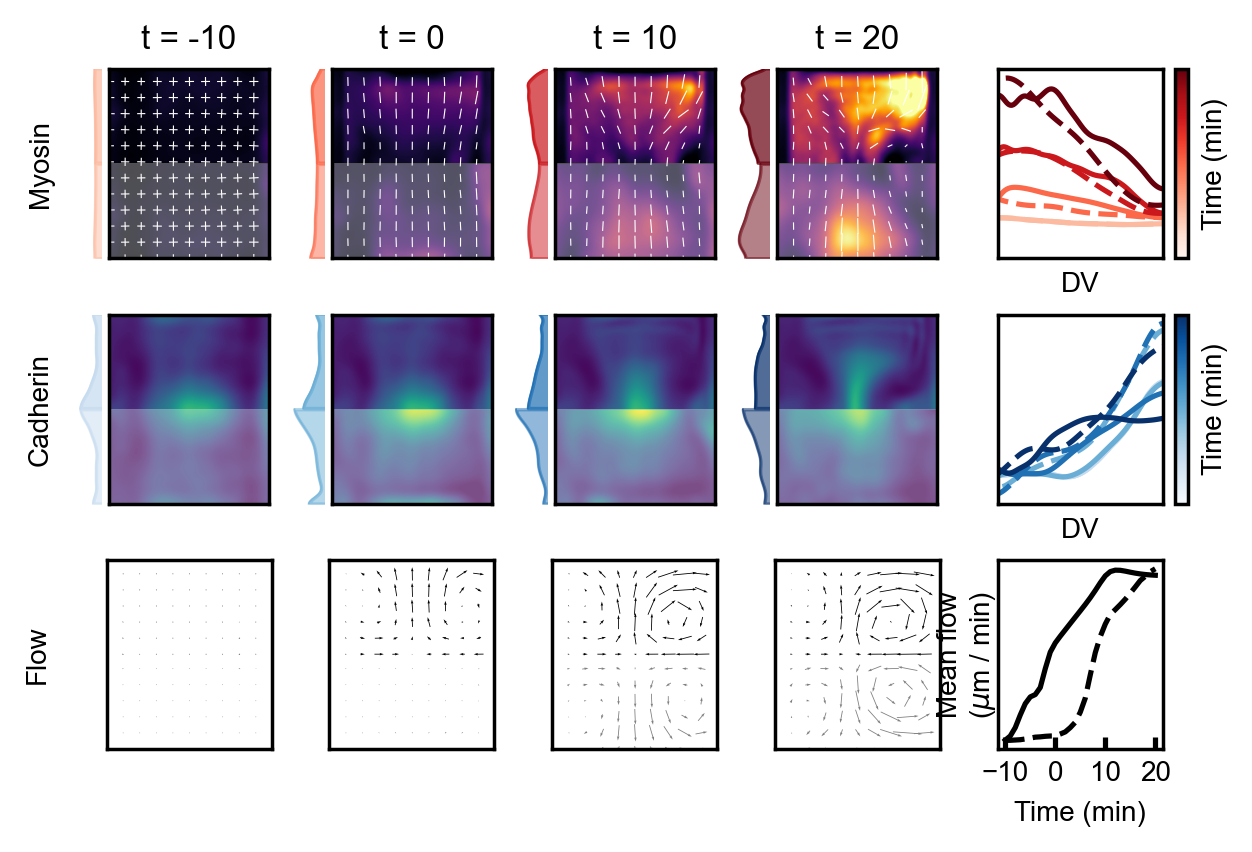

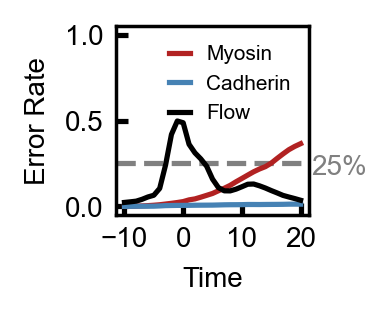

In [80]:
import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils.forecasting.closed_loop import ClosedFlyLoop
from utils.forecasting.plot_utils import *
from utils.vae.convnext_models import MaskedVAE_Evolver, VAE
from utils.decomposition.decomposition_model import LeftRightSymmetrize

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
info = torch.load('../tb_logs/May2023/forecasting_vae_v3.ckpt') #Works well with sigma = 3

vae = MaskedVAE_Evolver(**info['hparams'])
vae.load_state_dict(info['state_dict'])
vae = vae.double().to(device).eval();

#Collect initial conditions - m, c, v, and time
with h5py.File('Public/mechanical_feedback_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = -10, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]
    v0 = data['fields/v'][t_mask, ...][()]
    
    t0 = t[t_mask, ...][()]
    
#Calibrate flow strength
print('Calibrating flow model to movie intensity')
y0 = m0.reshape([-1, 4, 236, 200])
v1 = VAE.forward(vae, torch.from_numpy(y0).to(device))[0].cpu().detach().numpy()

scaler0 = MinMaxScaler().fit(np.linalg.norm(v0, axis=1).mean(axis=(1, 2))[:, None])
scaler1 = MinMaxScaler().fit(np.linalg.norm(v1, axis=1).mean(axis=(1, 2))[:, None])

def v_model(t, y):
    y = y.reshape([-1, 5, 236, 200])[:, :4]
    v = VAE.forward(vae, y)[0]
    
    vnorm = torch.linalg.norm(v, dim=1).mean(dim=(1, 2))
    vscale = vnorm * scaler1.scale_[0] + scaler1.min_[0] #Norm via a min-max scaler [0, 1]
    vscale = (vscale - scaler0.min_[0]) / scaler0.scale_[0] #Norm on the calibrated domain
    
    vscale = vscale / vnorm
    
    v = v * vscale[:, None, None, None]
    return v

y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    s0[0].reshape([1, *s0.shape[-2:]]),
])    
y0 = torch.from_numpy(y0)
model = ClosedFlyLoop(v_model, sigma=3) #Make sure self.rhs = self.rhs_WT_twist!
model.fit(y0[None])

m, s, v = model.integrate(y0.to(device), t0)

fig1, fig2 = comparison_plot(
    t0,
    ('Myosin', m, m0),
    ('Cadherin', s, s0),
    ('Flow', v, v0),
    dt=10)

# Learn model using Twist data only

In [81]:
from utils.library.composite_library import fill_group_info, collect_library, take_time_derivatives, decompose_library
from utils.library.extra_functions import *
        
libraries = [
    ('m_ij', 'Public/Halo_twist[ey53]/Sqh-GFP', 'tensor_library', 'tensor_SVDPipeline_PMG_CF.pkl'),
    ('v', 'Public/Halo_twist[ey53]/Sqh-GFP', 'tensor_library', None),
    ('c', 'Public/WT/ECad-GFP', 'scalar_library', None), #Not focused on cadherin dynamics, just include it as a source
]

    
extra_functions = [
    lambda data: material_derivative_terms(data, key='m_ij'),
    lambda data: active_strain_decomposition(data, key='m_ij'),
    lambda data: add_static_sources(data, couple='m_ij'),
    lambda data: symmetric_tensor_couple(data, ['m_ij', 'E_active', 'E_passive', 'E_full']),
    lambda data: multiply_tensor_by_scalar(data, None, ['c']),
]


with h5py.File(os.path.join(libraries[0][1], 'derivative_library.h5'), 'r') as h5f:
    embryoIDs = list(h5f.keys())
print(len(embryoIDs))
    
with h5py.File('Public/twist_only_fitting.h5', 'w') as data:
    with tqdm(total=len(embryoIDs)) as pbar:
        pbar.set_description('Collecting embryo data')
        for embryoID in embryoIDs:
            pbar.set_postfix(embryoID=embryoID)
            group, feature_names = fill_group_info(data, embryoID, libraries)
            collect_library(group, 
                            libraries, 
                            feature_names, 
                            extra_functions=extra_functions)
            take_time_derivatives(group, libraries, window_length=9)
            decompose_library(group, libraries)
            pbar.update()

6


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [85]:
from utils.modeling.sindy_utils import *
from utils.modeling.fly_sindy import *
np.set_printoptions(precision=3, suppress=True)

with h5py.File('Public/twist_only_fitting.h5', 'r') as h5f:
    X, X_dot, feature_names = collect_data(h5f, 'm_ij', collect_function=collect_raw_data,
                                           tmin=-5, tmax=10)

for threshold in [1e-3, 5e-3, 1e-2, 5e-2]:
    for alpha in [1e-1, 1e0, 1e1]:
        sindy = FlySINDy(
            optimizer=ps.STLSQ(threshold=threshold, alpha=alpha, normalize_columns=True),
            feature_names = feature_names,
            n_models=10,
            n_candidates_to_drop=0,
            subset_fraction=0.1)
        sindy.fit(x=X.copy(), x_dot=X_dot.copy())
        print(f'\nThreshold = {threshold:g}, Alpha = {alpha:g}')
        sindy.print(lhs=['D_t m_ij'])
        

  0%|          | 0/6 [00:00<?, ?it/s]


Threshold = 0.001, Alpha = 0.1
D_t m_ij = (0.025 + -0.030 c) E_ij + 0.263 E_ij Tr(m_ij) + (-0.002 + 0.001 c) Static_DV + (0.049 + -0.030 c) Static_DV Tr(m_ij) + 0.002 m_ij + (-1.293 + 0.737 c) m_ij Tr(E_ij) + (-0.090 + 0.102 c) m_ij Tr(m_ij) + (0.553 + -0.639 c) {m_ij, E_ij}

Threshold = 0.001, Alpha = 1
D_t m_ij = (-0.001 + 0.001 c) Static_DV + (0.032 + -0.023 c) Static_DV Tr(m_ij) + (-0.001 + -0.001 c) m_ij + (-1.140 + 0.677 c) m_ij Tr(E_ij) + (-0.061 + 0.133 c) m_ij Tr(m_ij)

Threshold = 0.001, Alpha = 10
D_t m_ij = (-0.002 + 0.002 c) Static_DV + (0.054 + -0.042 c) Static_DV Tr(m_ij) + (0.013 + -0.017 c) m_ij + (-0.241 + 0.319 c) m_ij Tr(m_ij)

Threshold = 0.005, Alpha = 0.1
D_t m_ij = -0.001 c Static_DV + (0.013 + 0.001 c) Static_DV Tr(m_ij) + 0.002 m_ij + -0.437 m_ij Tr(E_ij) + (0.049 + -0.002 c) m_ij Tr(m_ij)

Threshold = 0.005, Alpha = 1
D_t m_ij = (0.026 + -0.015 c) Static_DV Tr(m_ij) + (-0.015 + 0.008 c) m_ij + (0.067 + 0.044 c) m_ij Tr(m_ij)

Threshold = 0.005, Alpha = 10
D_

## Integrate twist-only model

Calibrating flow model to movie intensity
Initializing
Using torchdiffeq solver


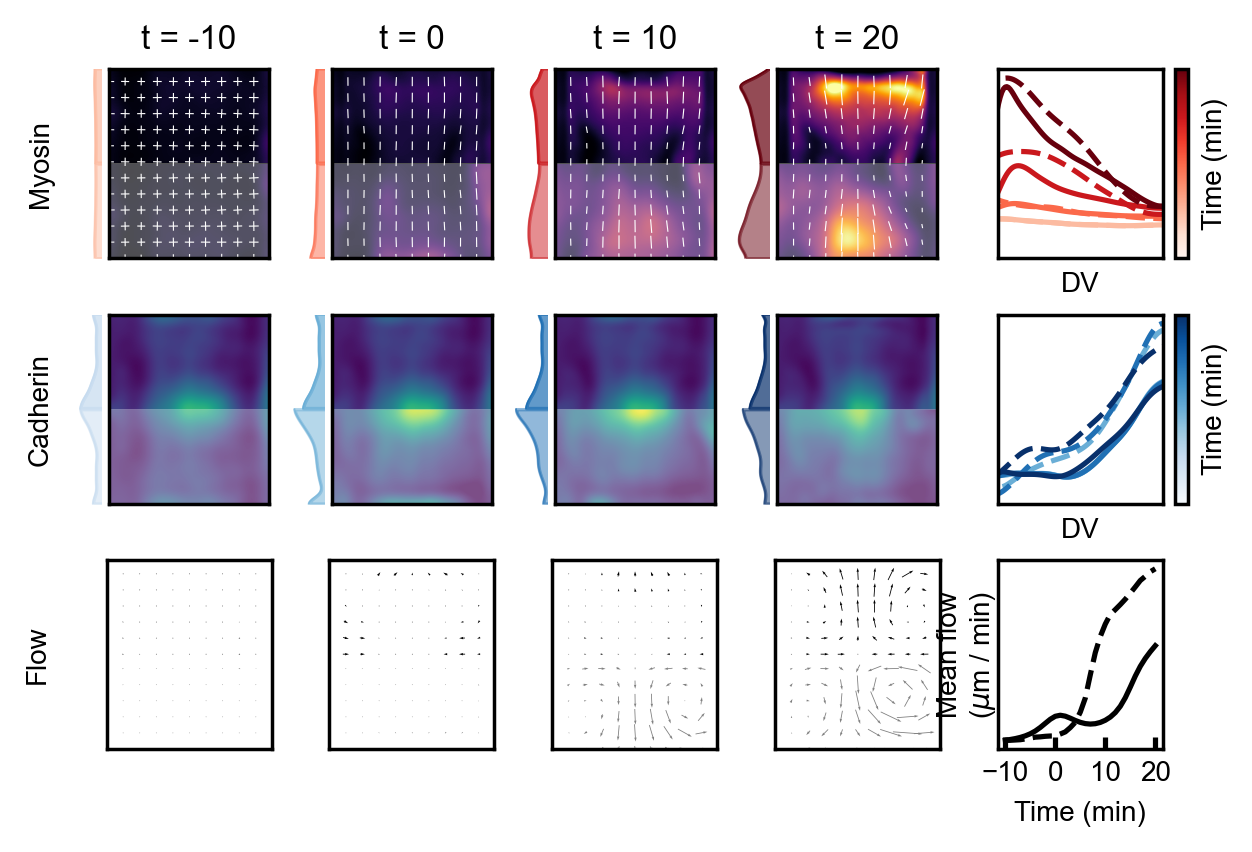

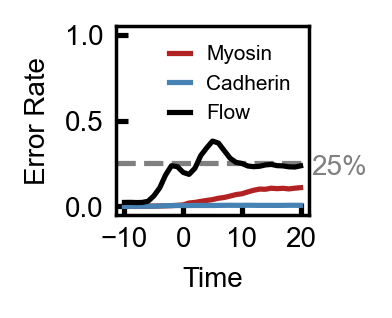

In [65]:
import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils.forecasting.closed_loop import ClosedFlyLoop
from utils.forecasting.plot_utils import *
from utils.vae.convnext_models import MaskedVAE_Evolver, VAE
from utils.decomposition.decomposition_model import LeftRightSymmetrize

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
info = torch.load('../tb_logs/May2023/forecasting_vae_v3.ckpt') #Works well with sigma = 3

vae = MaskedVAE_Evolver(**info['hparams'])
vae.load_state_dict(info['state_dict'])
vae = vae.double().to(device).eval();

#Collect initial conditions - m, c, v, and time
with h5py.File('Public/mechanical_feedback_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = -10, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]
    v0 = data['fields/v'][t_mask, ...][()]
    
    t0 = t[t_mask, ...][()]
    
#Calibrate flow strength
print('Calibrating flow model to movie intensity')
y0 = m0.reshape([-1, 4, 236, 200])
v1 = VAE.forward(vae, torch.from_numpy(y0).to(device))[0].cpu().detach().numpy()

scaler0 = MinMaxScaler().fit(np.linalg.norm(v0, axis=1).mean(axis=(1, 2))[:, None])
scaler1 = MinMaxScaler().fit(np.linalg.norm(v1, axis=1).mean(axis=(1, 2))[:, None])

def v_model(t, y):
    y = y.reshape([-1, 5, 236, 200])[:, :4]
    v = VAE.forward(vae, y)[0]
    
    vnorm = torch.linalg.norm(v, dim=1).mean(dim=(1, 2))
    vscale = vnorm * scaler1.scale_[0] + scaler1.min_[0] #Norm via a min-max scaler [0, 1]
    vscale = (vscale - scaler0.min_[0]) / scaler0.scale_[0] #Norm on the calibrated domain
    
    vscale = vscale / vnorm
    
    v = v * vscale[:, None, None, None]
    return v

y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    s0[0].reshape([1, *s0.shape[-2:]]),
])    
y0 = torch.from_numpy(y0)
model = ClosedFlyLoop(v_model, sigma=3) #Make sure self.rhs = self.rhs_WT_twist!
model.fit(y0[None])

m, s, v = model.integrate(y0.to(device), t0)

fig1, fig2 = comparison_plot(
    t0,
    ('Myosin', m, m0),
    ('Cadherin', s, s0),
    ('Flow', v, v0),
    dt=10)

# Learn model using Twist and WT data

In [54]:
from utils.library.composite_library import fill_group_info, collect_library, take_time_derivatives, decompose_library
from utils.library.extra_functions import *
        
libraries = [
    ('m_ij', 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP', 'tensor_library', 'tensor_SVDPipeline_PMG_CF.pkl'),
    ('m_ij', 'Public/Halo_twist[ey53]/Sqh-GFP', 'tensor_library', 'tensor_SVDPipeline_PMG_CF.pkl'),
    ('v', 'Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP', 'tensor_library', None), #Not focused on flow dynamics
    ('v', 'Public/Halo_twist[ey53]/Sqh-GFP', 'tensor_library', None),
    ('c', 'Public/WT/ECad-GFP', 'scalar_library', None), #Not focused on cadherin dynamics, just include it as a source
]

    
extra_functions = [
    lambda data: material_derivative_terms(data, key='m_ij'),
    lambda data: active_strain_decomposition(data, key='m_ij'),
    lambda data: add_static_sources(data, couple='m_ij'),
    lambda data: symmetric_tensor_couple(data, ['m_ij', 'E_active', 'E_passive', 'E_full']),
    lambda data: multiply_tensor_by_scalar(data, None, ['c']),
]


with h5py.File(os.path.join(libraries[0][1], 'derivative_library.h5'), 'r') as h5f:
    embryoIDs = list(h5f.keys())
with h5py.File(os.path.join(libraries[1][1], 'derivative_library.h5'), 'r') as h5f:
    embryoIDs = embryoIDs + list(h5f.keys())
print(len(embryoIDs))
    
with h5py.File('Public/twist_WT_fitting.h5', 'w') as data:
    with tqdm(total=len(embryoIDs)) as pbar:
        pbar.set_description('Collecting embryo data')
        for embryoID in embryoIDs:
            pbar.set_postfix(embryoID=embryoID)
            group, feature_names = fill_group_info(data, embryoID, libraries)
            collect_library(group, 
                            libraries, 
                            feature_names, 
                            extra_functions=extra_functions)
            take_time_derivatives(group, libraries, window_length=9)
            decompose_library(group, libraries)
            pbar.update()

13


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [75]:
with h5py.File('Public/twist_WT_fitting.h5', 'r') as h5f:
    X, X_dot, feature_names = collect_data(h5f, 'm_ij', collect_function=collect_raw_data,
                                           tmin=-5, tmax=10)

threshold, alpha = 1e-2, 1e1
sindy = FlySINDy(
    optimizer=ps.STLSQ(threshold=threshold, alpha=alpha, normalize_columns=True),
    feature_names = feature_names,
    n_models=10,
    n_candidates_to_drop=0,
    subset_fraction=0.1)
sindy.fit(x=X, x_dot=X_dot)
print(f'\nThreshold = {threshold:g}, Alpha = {alpha:g}')
sindy.print(lhs=['D_t m_ij'])

  0%|          | 0/13 [00:00<?, ?it/s]


Threshold = 0.01, Alpha = 10
D_t m_ij = (0.046 + -0.032 c) Static_DV Tr(m_ij) + (-0.076 + 0.059 c) m_ij + (0.376 + 0.408 c) m_ij Tr(E_ij) + (0.569 + -0.344 c) m_ij Tr(m_ij)


In [76]:
from utils.modeling.sindy_utils import *
from utils.modeling.fly_sindy import *
np.set_printoptions(precision=3, suppress=True)

with h5py.File('Public/twist_WT_fitting.h5', 'r') as h5f:
    X, X_dot, feature_names = collect_data(h5f, 'm_ij', collect_function=collect_raw_data,
                                           tmin=-5, tmax=10)

for threshold in [1e-3, 5e-3, 1e-2, 5e-2]:
    for alpha in [1e-1, 1e0, 1e1]:
        sindy = FlySINDy(
            optimizer=ps.STLSQ(threshold=threshold, alpha=alpha, normalize_columns=True),
            feature_names = feature_names,
            n_models=10,
            n_candidates_to_drop=0,
            subset_fraction=0.1)
        sindy.fit(x=X.copy(), x_dot=X_dot.copy())
        print(f'\nThreshold = {threshold:g}, Alpha = {alpha:g}')
        sindy.print(lhs=['D_t m_ij'])
        

  0%|          | 0/13 [00:00<?, ?it/s]


Threshold = 0.001, Alpha = 0.1
D_t m_ij = (0.033 + -0.037 c) E_ij + (-0.099 + 0.187 c) E_ij Tr(m_ij) + (0.055 + -0.040 c) Static_DV Tr(m_ij) + (-0.077 + 0.066 c) m_ij + (0.864 + -0.078 c) m_ij Tr(E_ij) + (0.546 + -0.373 c) m_ij Tr(m_ij) + (-1.345 + 1.359 c) {m_ij, E_ij}

Threshold = 0.001, Alpha = 1
D_t m_ij = -0.003 c E_ij + (0.113 + -0.027 c) E_ij Tr(m_ij) + (0.062 + -0.048 c) Static_DV Tr(m_ij) + (-0.080 + 0.072 c) m_ij + (0.850 + -0.063 c) m_ij Tr(E_ij) + (0.519 + -0.360 c) m_ij Tr(m_ij) + (-1.246 + 1.250 c) {m_ij, E_ij}

Threshold = 0.001, Alpha = 10
D_t m_ij = (0.031 + -0.035 c) E_ij + (-0.101 + 0.187 c) E_ij Tr(m_ij) + (0.052 + -0.038 c) Static_DV Tr(m_ij) + (-0.077 + 0.066 c) m_ij + (0.859 + -0.078 c) m_ij Tr(E_ij) + (0.559 + -0.366 c) m_ij Tr(m_ij) + (-1.283 + 1.299 c) {m_ij, E_ij}

Threshold = 0.005, Alpha = 0.1
D_t m_ij = (0.030 + -0.034 c) E_ij + (-0.027 + 0.118 c) E_ij Tr(m_ij) + (-0.001 + 0.001 c) Static_DV + (0.032 + -0.022 c) Static_DV Tr(m_ij) + -0.005 m_ij + (0.905 +

## Integrate WT+Twist model

Calibrating flow model to movie intensity
Initializing
Using torchdiffeq solver


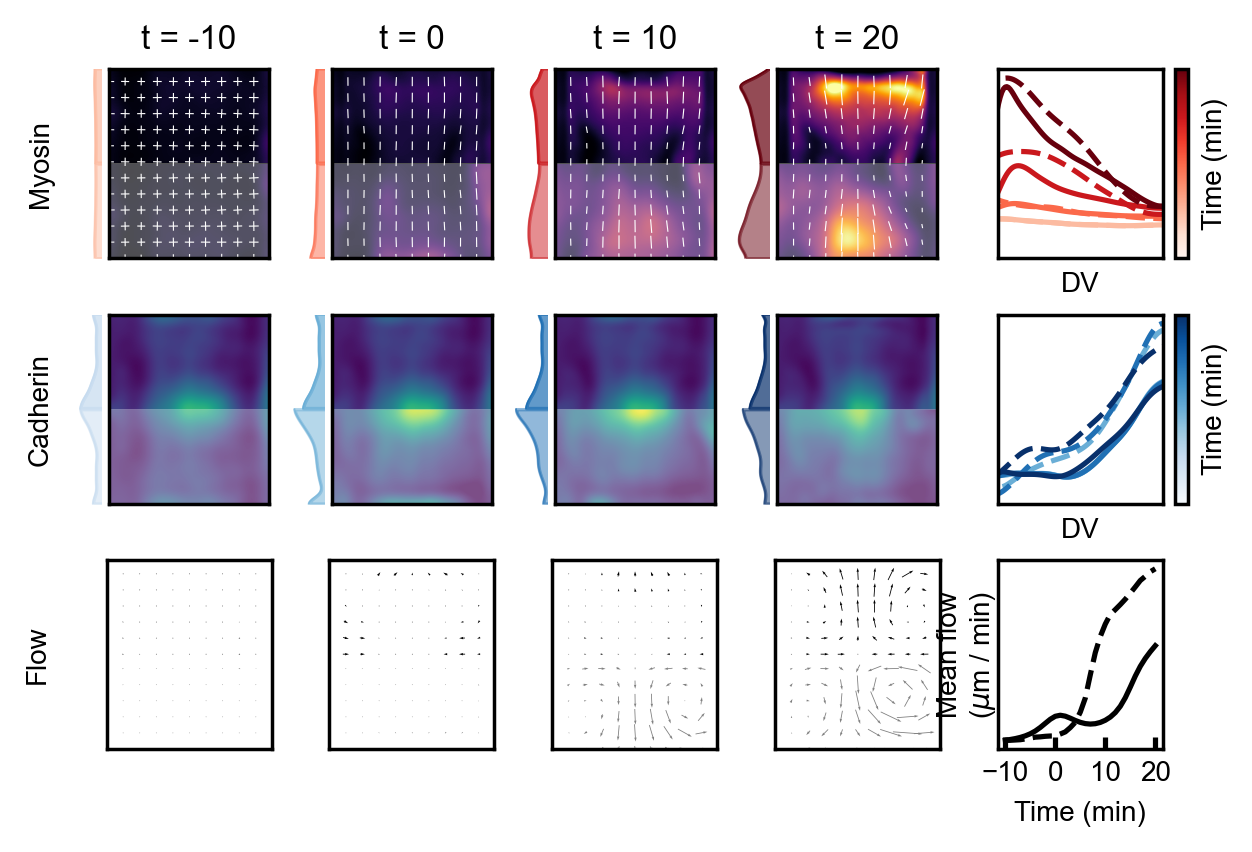

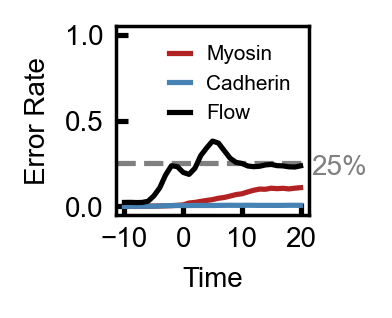

In [65]:
import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils.forecasting.closed_loop import ClosedFlyLoop
from utils.forecasting.plot_utils import *
from utils.vae.convnext_models import MaskedVAE_Evolver, VAE
from utils.decomposition.decomposition_model import LeftRightSymmetrize

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
info = torch.load('../tb_logs/May2023/forecasting_vae_v3.ckpt') #Works well with sigma = 3

vae = MaskedVAE_Evolver(**info['hparams'])
vae.load_state_dict(info['state_dict'])
vae = vae.double().to(device).eval();

#Collect initial conditions - m, c, v, and time
with h5py.File('Public/mechanical_feedback_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = -10, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]
    v0 = data['fields/v'][t_mask, ...][()]
    
    t0 = t[t_mask, ...][()]
    
#Calibrate flow strength
print('Calibrating flow model to movie intensity')
y0 = m0.reshape([-1, 4, 236, 200])
v1 = VAE.forward(vae, torch.from_numpy(y0).to(device))[0].cpu().detach().numpy()

scaler0 = MinMaxScaler().fit(np.linalg.norm(v0, axis=1).mean(axis=(1, 2))[:, None])
scaler1 = MinMaxScaler().fit(np.linalg.norm(v1, axis=1).mean(axis=(1, 2))[:, None])

def v_model(t, y):
    y = y.reshape([-1, 5, 236, 200])[:, :4]
    v = VAE.forward(vae, y)[0]
    
    vnorm = torch.linalg.norm(v, dim=1).mean(dim=(1, 2))
    vscale = vnorm * scaler1.scale_[0] + scaler1.min_[0] #Norm via a min-max scaler [0, 1]
    vscale = (vscale - scaler0.min_[0]) / scaler0.scale_[0] #Norm on the calibrated domain
    
    vscale = vscale / vnorm
    
    v = v * vscale[:, None, None, None]
    return v

y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    s0[0].reshape([1, *s0.shape[-2:]]),
])    
y0 = torch.from_numpy(y0)
model = ClosedFlyLoop(v_model, sigma=3) #Make sure self.rhs = self.rhs_WT_twist!
model.fit(y0[None])

m, s, v = model.integrate(y0.to(device), t0)

fig1, fig2 = comparison_plot(
    t0,
    ('Myosin', m, m0),
    ('Cadherin', s, s0),
    ('Flow', v, v0),
    dt=10)